<a href="https://colab.research.google.com/github/prekshya-dawadi/GDLLabs/blob/main/AISchool_moe_transformer_students.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The notebook runs best on a GPU. Click Runtime -> Change runtime type -> Select a GPU / T4 GPU option.


This notebook will show you how to implement and run Mixture of Expert on a Transformer architecture for text generation.

# Mixture of Experts Transformer

In deep learning, models typically reuse the same parameters for all inputs. Mixture of Experts (MoE) models defy this and instead select different parameters for each incoming example.

figure from: https://arxiv.org/pdf/2101.03961

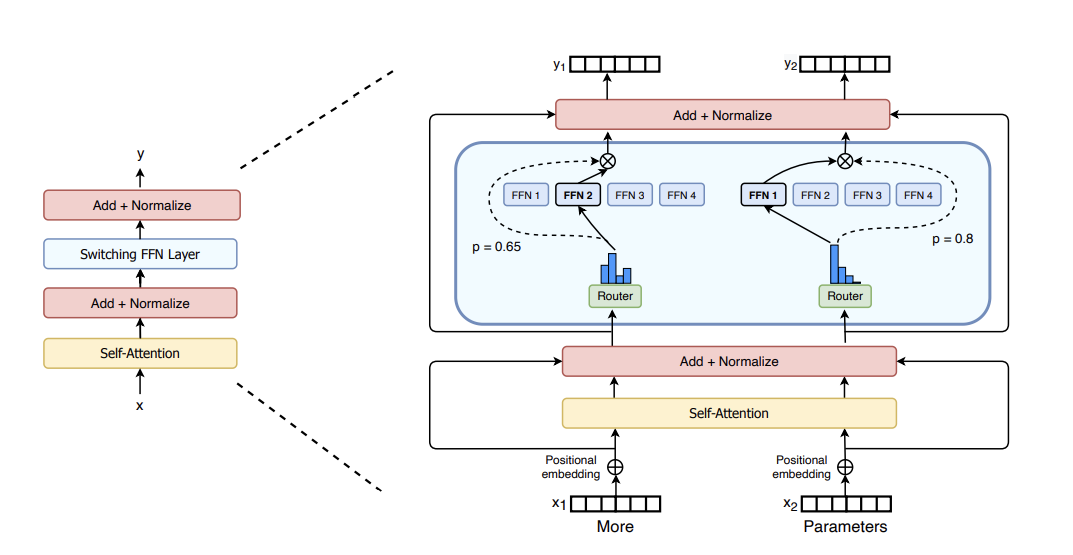

Download the TinyStories text dataset to learn text generation.

In [1]:
!wget https://huggingface.co/datasets/roneneldan/TinyStories/resolve/main/TinyStories_all_data.tar.gz

--2024-12-31 09:58:09--  https://huggingface.co/datasets/roneneldan/TinyStories/resolve/main/TinyStories_all_data.tar.gz
Resolving huggingface.co (huggingface.co)... 13.35.202.34, 13.35.202.97, 13.35.202.40, ...
Connecting to huggingface.co (huggingface.co)|13.35.202.34|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.hf.co/repos/42/7f/427f7497b6c6596c18b46d5a72e61364fcad12aa433c60a0dbd4d344477b9d81/26cf7605aca15bc4ea6fa637256400d9d01317b28ed296172b2d1dd160cd7699?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27TinyStories_all_data.tar.gz%3B+filename%3D%22TinyStories_all_data.tar.gz%22%3B&response-content-type=application%2Fgzip&Expires=1735898289&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTczNTg5ODI4OX19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5oZi5jby9yZXBvcy80Mi83Zi80MjdmNzQ5N2I2YzY1OTZjMThiNDZkNWE3MmU2MTM2NGZjYWQxMmFhNDMzYzYwYTBkYmQ0ZDM0NDQ3N2I5ZDgxLzI2Y2Y3NjA1YWNhMTViYzRlYTZmYTYzNz

# Prepare the dataset.

In [2]:
!mkdir TinyStories
!tar -xzf TinyStories_all_data.tar.gz -C TinyStories

In [3]:
import os
import glob
import json

In [4]:
shard_filenames = sorted(glob.glob(os.path.join('TinyStories', "*.json")))

In [5]:
with open(shard_filenames[0], "r") as f:
        data = json.load(f)

In [6]:
stories = [x['story'] for x in data]

The 'stories' variable contains short stories.
## 🚀 Your Task
Display one of the stories.

In [7]:
#YOUR CODE
print(stories[0])
#YOUR CODE



Lily and Ben are friends. They like to play in the park. One day, they see a big tree with a swing. Lily wants to try the swing. She runs to the tree and climbs on the swing.
"Push me, Ben!" she says. Ben pushes her gently. Lily feels happy. She swings higher and higher. She laughs and shouts.
Ben watches Lily. He thinks she is cute. He wants to swing too. He waits for Lily to stop. But Lily does not stop. She swings faster and faster. She is having too much fun.
"Can I swing too, Lily?" Ben asks. Lily does not hear him. She is too busy swinging. Ben feels sad. He walks away.
Lily swings so high that she loses her grip. She falls off the swing. She lands on the ground. She hurts her foot. She cries.
"Ow, ow, ow!" she says. She looks for Ben. She wants him to help her. But Ben is not there. He is gone.
Lily feels sorry. She wishes she had shared the swing with Ben. She wishes he was there to hug her. She limps to the tree. She sees something hanging from a branch. It is Ben's hat. He 

In [8]:
text = "\n".join(stories)

In [9]:
len(text)

77586884

Print the first 200 characters of the text.


In [10]:
#YOUR CODE
print(text[:200])
#YOUR CODE



Lily and Ben are friends. They like to play in the park. One day, they see a big tree with a swing. Lily wants to try the swing. She runs to the tree and climbs on the swing.
"Push me, Ben!" she say


In [11]:
import torch

## 🚀 Your Task

Create an array 'chars' that contrains the character vocabulary of the text, that is the list of all the characters used in the text.

Hint:
Use the set function to get unique the collection of unique characters in the text.


How many different characters are used?


In [12]:
# YOUR CODE
chars = [t for t in text]
chars = list(set(chars))
print(chars)
print(len(chars))
# YOUR CODE

['U', '|', ' ', 'K', 'g', '[', '2', ':', '5', 'Y', 'R', 'x', 'P', '3', '/', 'T', 'c', 'n', '—', 'D', 'B', 'A', ']', '(', "'", '&', 'O', 'F', 't', 'L', '0', '\t', '’', '–', 'Q', 'q', '8', '%', '9', '.', '?', 'o', '‘', '~', 'M', 's', 'C', 'é', 'd', '\xa0', 'z', '`', '"', 'I', 'N', ';', '…', '*', 'ñ', 'Z', 'y', '1', 'i', ')', ',', 'V', 'b', '“', '6', 'e', '7', '4', 'f', '”', 'W', '!', 'u', '\n', 'X', 'k', 'G', 'j', '$', '+', 'J', 'l', 'a', 'h', 'p', 'S', 'm', 'v', 'r', 'H', 'w', 'E', '-']
97


Characters are encoded using the stoi(string to integer) dictionary. The encoded characters are decoded back to characters using the itos(integer to string) dictionary.

In [13]:
stoi = { ch:i for i, ch in enumerate(chars) }
itos = {i:ch for i,ch in enumerate(chars)}
encode = lambda s: [stoi[c] for c in s]
decode = lambda l: "".join([itos[x] for x in l])

Encode the text "Hello there". Then decode it and verify if you get the same phrase.

In [14]:
# YOUR CODE
encoded = encode("Hello there")
print(encoded)
decoded = decode(encoded)
print(decoded)
# YOUR CODE

[93, 69, 85, 85, 41, 2, 28, 87, 69, 92, 69]
Hello there


Encode the entire dataset.

In [15]:
data = torch.tensor(encode(text), dtype = torch.long)

In [16]:
data.shape, type(data)

(torch.Size([77586884]), torch.Tensor)

Print the first 100 elements of the encoding.

In [17]:
# YOUR CODE
print(data[:100])
# YOUR CODE

tensor([77, 77, 29, 62, 85, 60,  2, 86, 17, 48,  2, 20, 69, 17,  2, 86, 92, 69,
         2, 72, 92, 62, 69, 17, 48, 45, 39,  2, 15, 87, 69, 60,  2, 85, 62, 79,
        69,  2, 28, 41,  2, 88, 85, 86, 60,  2, 62, 17,  2, 28, 87, 69,  2, 88,
        86, 92, 79, 39,  2, 26, 17, 69,  2, 48, 86, 60, 64,  2, 28, 87, 69, 60,
         2, 45, 69, 69,  2, 86,  2, 66, 62,  4,  2, 28, 92, 69, 69,  2, 94, 62,
        28, 87,  2, 86,  2, 45, 94, 62, 17,  4])


Create a validation dataset. The train dataset is already provided. The validation dataset contains remaining samples.

In [18]:
n = int(0.9*len(data))
train_data = data[:n]

# YOUR CODE
val_data = data[n:]
# YOUR CODE

Defining the block size, which is the length of the (context) input.


In [19]:
block_size = 8

In [20]:
train_data[:block_size+1]

tensor([77, 77, 29, 62, 85, 60,  2, 86, 17])

In [21]:
x = train_data[:block_size]

In [22]:
y = train_data[1:block_size+1]

In [23]:
x,y

(tensor([77, 77, 29, 62, 85, 60,  2, 86]),
 tensor([77, 29, 62, 85, 60,  2, 86, 17]))

For every element in the context, print the context so far. The next token is the target.

In [24]:
for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print("ctx ", context, "target", target)

ctx  tensor([77]) target tensor(77)
ctx  tensor([77, 77]) target tensor(29)
ctx  tensor([77, 77, 29]) target tensor(62)
ctx  tensor([77, 77, 29, 62]) target tensor(85)
ctx  tensor([77, 77, 29, 62, 85]) target tensor(60)
ctx  tensor([77, 77, 29, 62, 85, 60]) target tensor(2)
ctx  tensor([77, 77, 29, 62, 85, 60,  2]) target tensor(86)
ctx  tensor([77, 77, 29, 62, 85, 60,  2, 86]) target tensor(17)


In [25]:
torch.manual_seed(1337)

In [26]:
batch_size = 4

In [27]:
block_size = 8

In [28]:
# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x, y

In [29]:
xb, yb = get_batch('train')

In [30]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [31]:
yb

tensor([[ 2, 52, 46, 86, 17,  2, 53,  2],
        [77, 29, 62, 85, 60, 24, 45,  2],
        [62, 45, 60,  2, 94, 86, 45,  2],
        [77, 74, 87, 69, 17,  2, 28, 87]])

In [32]:
for b in range(batch_size):
    for t in range(block_size):
        context = xb[b][:t+1]
        target = yb[b][t]
        print(context, "-----", target)

tensor([64]) ----- tensor(2)
tensor([64,  2]) ----- tensor(52)
tensor([64,  2, 52]) ----- tensor(46)
tensor([64,  2, 52, 46]) ----- tensor(86)
tensor([64,  2, 52, 46, 86]) ----- tensor(17)
tensor([64,  2, 52, 46, 86, 17]) ----- tensor(2)
tensor([64,  2, 52, 46, 86, 17,  2]) ----- tensor(53)
tensor([64,  2, 52, 46, 86, 17,  2, 53]) ----- tensor(2)
tensor([2]) ----- tensor(77)
tensor([ 2, 77]) ----- tensor(29)
tensor([ 2, 77, 29]) ----- tensor(62)
tensor([ 2, 77, 29, 62]) ----- tensor(85)
tensor([ 2, 77, 29, 62, 85]) ----- tensor(60)
tensor([ 2, 77, 29, 62, 85, 60]) ----- tensor(24)
tensor([ 2, 77, 29, 62, 85, 60, 24]) ----- tensor(45)
tensor([ 2, 77, 29, 62, 85, 60, 24, 45]) ----- tensor(2)
tensor([86]) ----- tensor(62)
tensor([86, 62]) ----- tensor(45)
tensor([86, 62, 45]) ----- tensor(60)
tensor([86, 62, 45, 60]) ----- tensor(2)
tensor([86, 62, 45, 60,  2]) ----- tensor(94)
tensor([86, 62, 45, 60,  2, 94]) ----- tensor(86)
tensor([86, 62, 45, 60,  2, 94, 86]) ----- tensor(45)
tensor([

In [33]:
vocab_size = len(chars)

In [34]:
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1137)

The MoeLayer (Mixture of Experts Layer) implements a mechanism where inputs are dynamically routed to a subset of "experts" (submodels). A gating network (self.gate) computes logits for each input instance, where the logits determine the probability of routing each input to specific experts. Simply copy the arguments at the init method. Then write a line of code to select top-k experts. Hint: use torch.topk

# Mixture of Experts Layer (MoE Layer)

## Overview

The **MoeLayer** (Mixture of Experts Layer) dynamically routes inputs to a subset of "experts" (submodels) using a gating mechanism. The gating network (`self.gate`) computes logits for routing inputs to the top-`k` experts, improving efficiency and scalability.

## Class Definition

Here you will initialize a **MoeLayer**. In the class **Block** (which is a transformer block), the `experts` variable is an array of **FeedForward** layers (there are `num_experts` of them), each taking `n_embed` as input. The **Gate (router)** is a linear layer of size `n_embed × num_experts` (with no bias). Also, specify the number of experts to **8**.

## Task Instructions

1. **Initialize `self.gate`**: Assign the provided gating network.
2. **Set `self.k`**: Assign the number of top experts to `self.k`.
3. **Select top-`k` experts**: Use **`torch.topk`** to select the indices and weights of the top-`k` experts.




## 🚀 **Your Taks and Hints**
- 💡 Use `torch.topk`: _Example: `weights, indices = torch.topk(tensor, k, dim=1)`_
- 💡 The `weights` are scaled using `nn.functional.softmax` to compute the final contribution of each expert.

That's it—good luck! 💻✨

In [35]:
class MoeLayer(nn.Module):
    def __init__(self, experts, gate, k=1):
        super().__init__()
        assert len(experts) > 0
        self.experts = nn.ModuleList(experts)
        self.gate = gate
        self.k = k

    def forward(self, inputs: torch.Tensor):
        inputs_squashed = inputs.view(-1, inputs.shape[-1])
        gate_logits = self.gate(inputs_squashed)
        # Select top-k experts
        weights, selected_experts = torch.topk(gate_logits, self.k)
        # The contribution of this expert to the final result is scaled by its corresponding weight.
        weights = nn.functional.softmax(
            weights,
            dim=1,
            dtype=torch.float,
        ).type_as(inputs)
        # The results variable in the forward method of the MoeLayer class is used to accumulate the outputs from the selected experts for all inputs.
        results = torch.zeros_like(inputs_squashed)
        for i, expert in enumerate(self.experts):
           #nth_expert identifies the position in the top k list for those inputs.
            batch_idx, nth_expert = torch.where(selected_experts == i)
            # the weights are specific to the inputs routed to each expert. batch_idx identifies the specific input instances that are routed to a particular expert (determined by torch.where(selected_experts == i)).
            results[batch_idx] += weights[batch_idx, nth_expert, None] * expert(
                inputs_squashed[batch_idx]
            )
        return results.view_as(inputs)

# Transformer Components

## Overview

This section defines key components of a Transformer architecture, including self-attention, multi-head attention, feedforward layers, and a Mixture of Experts (MoE) mechanism.

---

## Class Descriptions

### 1. **Head**
Defines a single self-attention mechanism:
- **Key**, **Query**, and **Value** are learned projections of size `head_size`.
- A lower triangular matrix (`tril`) ensures causal masking, so tokens can only attend to previous ones.
- Performs scaled dot-product attention.

### 2. **MultiHeadAttention**
Implements multi-head attention:
- Composed of multiple `Head` instances for parallel processing.
- Outputs concatenated attention from all heads, followed by a projection.

### 3. **FeedForward**
Defines a two-layer fully connected network with activation and dropout:
- Expands the input dimensionality (`n_embed`) by a factor of 4 before projecting back.

### 4. **Block**
Combines self-attention and feedforward with a Mixture of Experts (MoE):
- **`sa_head`**: Multi-head self-attention.
- **`ffw`**: MoE Layer using `experts` and a gating mechanism.
- Normalization layers (`ln1`, `ln2`) stabilize training.

#### MoE Configuration in Block
- **`experts`**: An array of `FeedForward` layers with `num_experts` elements.
- **`gate`**: A linear layer mapping `n_embed` to `num_experts` without bias.

### 5. **Transformer**
Combines embedding layers, sequential blocks, and a language modeling head:
- **Token Embedding**: Maps vocabulary indices to embedding vectors.
- **Position Embedding**: Encodes token positions in the sequence.
- **Blocks**: A stack of Transformer blocks.
- **Language Model Head**: Projects embeddings to vocabulary logits.

### Additional Features
- **`forward`**: Processes input tokens through the Transformer stack.
- **`generate`**: Autoregressively generates tokens, ensuring causal masking.

---





## 💡 Your Task
- Define `experts` as `FeedForward` layers (size `num_experts`).
- The **gate** is a linear layer with size `n_embed × num_experts`.
- Specify `num_experts` explicitly (e.g., `num_experts=8`) when initializing a `Block`.


In [36]:
class Head(nn.Module):
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embed, head_size, bias = False)
        self.query = nn.Linear(n_embed, head_size, bias = False)
        self.value = nn.Linear(n_embed, head_size, bias = False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(dropout)


    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x)
        q = self.query(x)
        wei = q @ k.transpose(-2, -1) * C**-0.5
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)
        v = self.value(x)
        out = wei @ v
        return out

class MulitHeadAttention(nn.Module):
    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embed, n_embed)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x =  torch.cat([head(x) for head in self.heads], dim=-1)
        out = self.dropout(self.proj(x))
        return out


class FeedForward(nn.Module):
    def __init__(self, n_embed):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embed, 4* n_embed),
            nn.ReLU(),
            nn.Linear(4 * n_embed, n_embed),
         nn.Dropout(dropout))

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    def __init__(self, n_embed, n_head, num_experts= 8):
        print("Experts num: ", num_experts)
        super().__init__()
        self.sa_head= MulitHeadAttention(n_head, n_embed//n_head)
        self.ffw = MoeLayer(
            experts = [FeedForward(n_embed) for n in range(num_experts)],
            gate=nn.Linear(n_embed, num_experts),
        )

        self.ln1 = nn.LayerNorm(n_embed)
        self.ln2 = nn.LayerNorm(n_embed)

    def forward(self, x):
        x = x + self.sa_head(self.ln1(x))
        x = x+self.ffw(self.ln2(x))
        return x



In [37]:

class Transformer(nn.Module):
    def __init__(self):
        super().__init__()

        self.token_embedding_table = nn.Embedding(vocab_size, n_embed, device=device)
        self.position_embedding_table = nn.Embedding(block_size, n_embed, device=device)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.lm_head = nn.Linear(n_embed, vocab_size)


    def forward(self, idx, targets=None):
        B, T = idx.shape

        token_emb = self.token_embedding_table(idx)
        pos_emb = self.position_embedding_table(torch.arange(T).to(device))
        x = token_emb + pos_emb
        x = self.blocks(x)
        logits = self.lm_head(x)
        if targets == None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)
        return logits, loss

    def generate(self, idx, max_new_tokes):
        for _ in range(max_new_tokes):
            idx_cond = idx[:, -block_size:]
            logits, loss = self(idx_cond)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim = -1)
            idx_next = torch.multinomial(probs, num_samples = 1)
            idx = torch.cat((idx, idx_next), dim = 1)
        return idx

# Hyperparameters

In [38]:
# hyperparameters
batch_size = 64 # how many independent sequences will we process in parallel?
block_size = 256 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 100
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 384
n_embed = 384
n_head = 6
n_layer = 6
dropout = 0.0
# ------------

The Transformer class gets initialized.

In [39]:
model = Transformer()
optimizer = torch.optim.AdamW(model.parameters(),lr=learning_rate)

Experts num:  8
Experts num:  8
Experts num:  8
Experts num:  8
Experts num:  8
Experts num:  8


# `estimate_loss` Function

## Purpose
The `estimate_loss` function calculates the average loss for both training and validation datasets, providing an evaluation of the model's performance without updating weights.

##  Steps
1. **Set Evaluation Mode**:  
   `model.eval()` disables dropout and other training-specific layers.
   
2. **Iterate Through Splits**:  
   Loops over `train` and `val` datasets.
   
3. **Batch Evaluation**:  
   - Collects a batch of data (`X`, `Y`) using `get_batch`.
   - Moves data to the appropriate device.
   - Computes the model's `logits` and `loss`.

4. **Store Loss**:  
   Collects losses across `eval_iters` iterations and computes the mean for each split.

5. **Return to Training Mode**:  
   `model.train()` re-enables training behavior.

## Output
- A dictionary `out` with average loss values for `train` and `val` splits.



In [40]:
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            X = X.to(device)
            Y = Y.to(device)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [41]:
device

'cuda'

In [42]:
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(),lr=1e-4)

Run the training. Record the loss at the end after 300 iterations. Then change the number of experts to 1 in the cell with class defintions, and rerun the cells from that point onwards. How did the val loss change? Feel free to experiment with other number of experts.

In [ ]:

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % 100 == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')
    xb = xb.to(device)
    yb = yb.to(device)

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

step 0: train loss 4.9281, val loss 4.9289
step 100: train loss 2.3373, val loss 2.3385
step 200: train loss 2.3060, val loss 2.3072
step 300: train loss 2.2795, val loss 2.2797
step 400: train loss 2.2340, val loss 2.2336
step 500: train loss 2.1305, val loss 2.1292


See the results of the trained model for yourself. For better results you may need to train for larger number of iterations. But just play with it. Congratulations, you have implemented your Mixture of Experts Transformer text generative model! Have fun playing with it!

In [ ]:
d = 'once upon a time there was an AI school in the Himalayas. '
x = torch.tensor(encode(d), dtype = torch.long,device=device).unsqueeze(0)
print(decode(model.generate(x, max_new_tokes=500)[0].tolist()))


In [ ]:
d = 'One day in Nepal '
x = torch.tensor(encode(d), dtype = torch.long,device=device).unsqueeze(0)
print(decode(model.generate(x, max_new_tokes=500)[0].tolist()))
